**This is the finalized model training notebook for the Quora Insincere Questions Classification project which is also my Springboard ML Course's Capstone Project**

*Import all the dependencies and mount the Google Drive to access the training file*

In [0]:
import re
import os

import unicodedata

import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd

from datetime import datetime
from pytz import timezone
import time

from sklearn.model_selection import train_test_split

# You will have to download the set of stop words the first time
import nltk
nltk.download('stopwords')

# Load stop words
stop_words = stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')


from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/kaggle/quora')
!ls -ltr

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
total 12041214
-rw------- 1 root root 5646236541 Oct 24  2015 glove.840B.300d.txt
-rw------- 1 root root 2259088777 Mar 14  2018 wiki-news-300d-1M.vec
-rw------- 1 root root 3644258522 Oct 31  2018 GoogleNews-vectors-negative300.bin
drwx------ 2 

*Build a contraction map for expanding contractions to be used in preprocessing step*

In [0]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

*Define all the functions for preprocessing the data, plotting the confusion matrix and printing the scores of classification task*

In [0]:


from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
  #  classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


  
  


def remove_special_chars(text):
  return re.sub(r'[^a-zA-Z0-9 \']', '', text)

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def tokenize_text(text):
  tokens = nltk.word_tokenize(text)
  tokens = [token.strip() for token in tokens]
  return tokens

def normalize_text(text):
  text=remove_special_chars(text)
  text=expand_contractions(text)
  text=text.lower()
  text=remove_accented_chars(text)
  return text

def remove_stopwords_nltk(tokens):
  filtered_tokens = [token for token in tokens if token not in stop_words]
  filtered_text = ' '.join(filtered_tokens)    
  return filtered_text




def stem_sentences_nltk(sentence):
  ps = PorterStemmer()
  tokens = sentence.split()
  stemmed_tokens = [ps.stem(token) for token in tokens]
  return ' '.join(stemmed_tokens)



 
def tfidf_vectorize_get_array(series):
  vectorizer = TfidfVectorizer(min_df=1,norm='l2',smooth_idf=True,use_idf=True,ngram_range=(1,1))
  return np.array(vectorizer.fit_transform(series).todense(), dtype=np.float16)

def tfidf_vectorize(series):
  vectorizer = TfidfVectorizer(min_df=1,norm='l2',smooth_idf=True,use_idf=True,ngram_range=(1,1))
  return vectorizer.fit_transform(series)

def preprocess_text(df,stem=False):
  if stem:
    df['word_tokens_stemmed']=df['question_text'].apply(normalize_text).apply(tokenize_text).apply(remove_stopwords_nltk).apply(stem_sentences_nltk)
  else:
    df['word_tokens_stemmed']=df['question_text'].apply(normalize_text).apply(tokenize_text).apply(remove_stopwords_nltk)
  
  return df




def split_train_test(df):
  x_train,x_test,y_train,y_test = train_test_split(df['word_tokens_stemmed'],df['target'], random_state=1,stratify=df['target'])
  return x_train,x_test,y_train,y_test

def classifier_reports(y_test, y_pred):
  print()
  class_names = ['class0', 'class1']
  print(classification_report(y_test, y_pred, target_names=class_names))
  # Plot non-normalized confusion matrix
  plot_confusion_matrix(y_test, y_pred, classes=class_names,title='Confusion matrix, without normalization')
  # Plot normalized confusion matrix
  plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
  plt.show()

*Read the training file, perform preprocessing and split the dataset into training and test set*

In [0]:



df=pd.read_csv('train.csv')

pd.options.display.max_colwidth = 500
print('Number rows and columns:',df.shape)

df=preprocess_text(df,True) 

x_train,x_test,y_train,y_test=split_train_test(df)



df.head()

Number rows and columns: (1306122, 3)


,qid,question_text,target,word_tokens_stemmed
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0,quebec nationalist see provinc nation 1960
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0,adopt dog would encourag peopl adopt not shop
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0,veloc affect time veloc affect space geometri
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0,otto von guerick use magdeburg hemispher
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0,convert montra helicon mountain bike chang tyre


*Train the model using the best parameters of logistic regression found by Grid search and print the score and plot the confusion matrix*

LogisticRegression


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.



              precision    recall  f1-score   support

      class0       0.99      0.87      0.92    306328
      class1       0.31      0.89      0.46     20203

    accuracy                           0.87    326531
   macro avg       0.65      0.88      0.69    326531
weighted avg       0.95      0.87      0.90    326531

Confusion matrix, without normalization
[[265398  40930]
 [  2148  18055]]
Normalized confusion matrix
[[0.86638505 0.13361495]
 [0.10632084 0.89367916]]


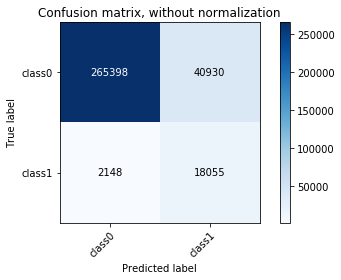

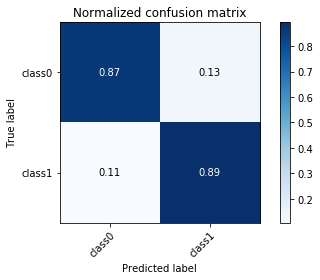


Wed, 23 October 2019 16:29:57


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score,precision_recall_curve,precision_recall_fscore_support

clf = LogisticRegression(class_weight='balanced',C=1,penalty='l2',random_state=42,solver='liblinear')
     
name = clf.__class__.__name__
print(name)
text_clf = Pipeline([('vect', TfidfVectorizer(min_df=1,norm='l2',smooth_idf=True,use_idf=True,ngram_range=(1,1))),('clf', clf)])
text_clf.fit(x_train, y_train)


pred_proba_df = pd.DataFrame(text_clf.predict_proba(x_test))
y_pred = pred_proba_df.applymap(lambda x: 1 if x>0.4 else 0)
classifier_reports(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                           y_pred.iloc[:,1].as_matrix().reshape(y_pred.iloc[:,1].as_matrix().size,1))   
acc = metrics.accuracy_score(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                           y_pred.iloc[:,1].as_matrix().reshape(y_pred.iloc[:,1].as_matrix().size,1))
    

    
print()
EST = timezone('US/Eastern')
EST_Time = datetime.now(EST)
print(EST_Time.strftime("%a, %d %B %Y %H:%M:%S"))
    
   
    

plt.show()





*Save the model in a file to be loaded into memory later for model inference*

In [0]:
import pickle

filename='quora_classification_model.sav'

pickle.dump(text_clf, open(filename, 'wb'))


*Test the saved model by loading into memory and performing prediction using the loaded model*

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':



              precision    recall  f1-score   support

      class0       0.99      0.87      0.92    306328
      class1       0.31      0.89      0.46     20203

    accuracy                           0.87    326531
   macro avg       0.65      0.88      0.69    326531
weighted avg       0.95      0.87      0.90    326531

Confusion matrix, without normalization
[[265398  40930]
 [  2148  18055]]
Normalized confusion matrix
[[0.86638505 0.13361495]
 [0.10632084 0.89367916]]


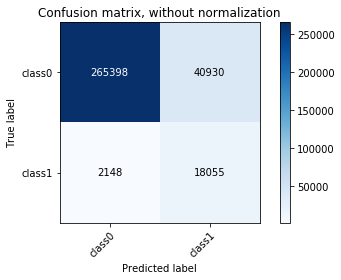

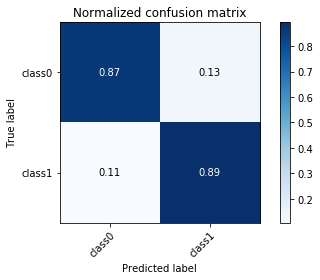


Wed, 23 October 2019 18:33:05


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [0]:
load_clf_model =pickle.load(open(filename, 'rb'))

y_load_predit=load_clf_model.predict_proba(x_test)


pred_proba_df = pd.DataFrame(load_clf_model.predict_proba(x_test))
y_pred = pred_proba_df.applymap(lambda x: 1 if x>0.4 else 0)
classifier_reports(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                           y_pred.iloc[:,1].as_matrix().reshape(y_pred.iloc[:,1].as_matrix().size,1))   
acc = metrics.accuracy_score(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                           y_pred.iloc[:,1].as_matrix().reshape(y_pred.iloc[:,1].as_matrix().size,1))
    

    
print()
EST = timezone('US/Eastern')
EST_Time = datetime.now(EST)
print(EST_Time.strftime("%a, %d %B %Y %H:%M:%S"))
    
   
    

plt.show()




